In [1]:
!pip install tifffile -q
!pip install imagecodecs -q
!pip3 install opencv-python==4.8.0.74 -q
!pip install mlflow -q
!pip install torchmetrics -q
!pip install albumentations -q
!pip install segmentation-models-pytorch -q
!pip install kfp -q
!pip show kfp
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import cv2
import glob
import os
import numpy as np
# import gdal
import matplotlib.pyplot as plt
import regex as re
import tifffile as tiff
from PIL import Image
import seaborn as sns
import albumentations as A
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW
import mlflow
from kfp import dsl
from google.colab import drive
drive.mount('/content/drive')
import kfp
import kfp.components as comp
import requests
import kfp.dsl as dsl
import streamlit as st

MessageError: ignored

In [ ]:
# `streamlit hello`

In [ ]:
# st.text_input("Project Secret", key="project_secret")
# st.text_input("Model Key" , key="model_key")

2023-12-08 00:43:37.592 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


''

In [ ]:
# images_list = list(glob.glob(os.path.join(DATA_ROOT, "images", "*.tif")))
# print('images_list:',len(images_list))

images_list: 41


In [ ]:
# image1 = re.sub(r'\\', '/', images_list[0])
# image2 = re.sub(r'\\', '/', images_list[1])
# image3 = re.sub(r'\\', '/', images_list[2])
# image4 = re.sub(r'\\', '/', images_list[3])

In [ ]:
# print('image1:',image1)
# print('image2:',image2)

image1: /content/drive/MyDrive/inputs/images/M-33-20-D-c-4-2.tif
image2: /content/drive/MyDrive/inputs/images/M-33-20-D-d-3-3.tif


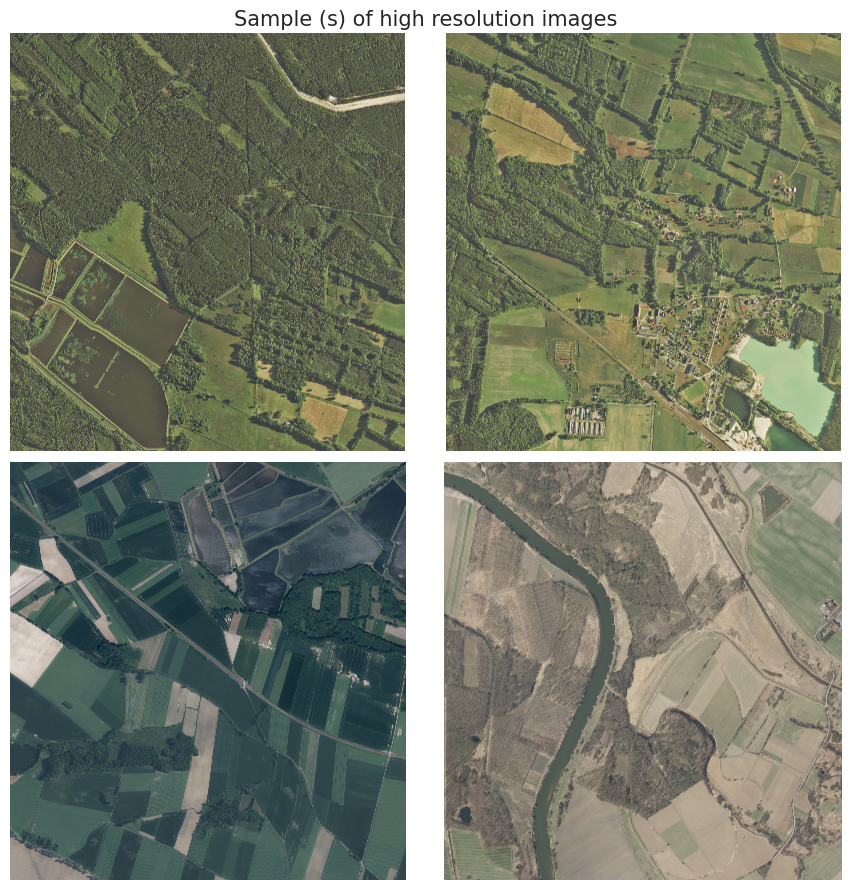

In [ ]:
# fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)

# ax[0,0].imshow(tiff.imread(image1))
# ax[0,0].axis("off")

# ax[0,1].imshow(tiff.imread(image2))
# ax[0,1].axis("off")

# ax[1,0].imshow(tiff.imread(image3))
# ax[1,0].axis("off")

# ax[1,1].imshow(tiff.imread(image4))
# ax[1,1].axis("off")

# plt.suptitle("Sample (s) of high resolution images", fontsize = 15)
# plt.tight_layout(pad=0.8)
# plt.show()

In [7]:
import matplotlib
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9",
        "#8B8680", "#D3D3D3", "#FFFFFF"])

def visualize_dataset(num_samples = 8, seed = 42,
                     w = 10, h = 10, nrows = 4, ncols = 4, save_title = None,
                     pad = 0.8, indices = None):
    """
    A function to visualize the images of the dataset along with their
    corresponding masks.
    """
    DATA_ROOT = "/content/drive/MyDrive/inputs"

    OUTPUT_DIR = DATA_ROOT + "/output"

    data_list = list(glob.glob(os.path.join(OUTPUT_DIR, "*.jpg")))
    if indices == None:
        np.random.seed(seed)
        indices = np.random.randint(low = 0, high = len(data_list), size = num_samples)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize = (h,w), nrows = num_samples//2,
                           ncols = 4)
    for i, idx in enumerate(indices):
        r,rem = divmod(i,2)
        img = cv2.imread(data_list[idx])/255
        mask_pt = data_list[indices[i]].split(".jpg")[0] + "_m.png"
        mask = cv2.imread(mask_pt)[:,:,1]
        ax[r,2*rem].imshow(img)
        ax[r,2*rem].set_title("Sample"+str(i+1))
        ax[r,2*rem+1].imshow(mask, cmap = labels_cmap, interpolation = None,
                            vmin = -0.5, vmax = 4.5)
        ax[r,2*rem+1].set_title("Mask" + str(i+1))
    plt.suptitle("Samples of 512 x 512 images", fontsize = 20)
    plt.tight_layout(pad = 0.8)
    if save_title is not None:
        plt.savefig(save_title + ".png")
    plt.show()

In [ ]:
@dsl.component(base_image='python:3.9.0', packages_to_install=['pandas==2.1.3','numpy==1.21.0','opencv==4.7.0','matplotlib==3.8.2','seaborn=0.13.0','tifffile==2023.9.26'])
def prepare_data():
    import cv2
    import glob
    import os
    import numpy as np
    # import gdal
    import matplotlib.pyplot as plt
    import seaborn as sns
    import regex as re
    import tifffile as tiff
    from PIL import Image


    sns.set_style("dark")

    DATA_ROOT = "/content/drive/MyDrive/inputs"

    IMGS_DIR = DATA_ROOT + "/images"
    MASKS_DIR = DATA_ROOT + "/masks"
    OUTPUT_DIR = DATA_ROOT + "/output"

    TARGET_SIZE = 512

    img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
    mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))
    print(len(img_paths))
    print(len(mask_paths))
    img_paths.sort()
    mask_paths.sort()

    os.makedirs(OUTPUT_DIR)

    for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
        img_filename = os.path.splitext(os.path.basename(img_path))[0]
        mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

        k = 0
        for y in range(0, img.shape[0], TARGET_SIZE):
            for x in range(0, img.shape[1], TARGET_SIZE):
                img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
                mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

                if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                    out_img_path = os.path.join(OUTPUT_DIR, "{}_{}.jpg".format(img_filename, k))
                    cv2.imwrite(out_img_path, img_tile)

                    out_mask_path = os.path.join(OUTPUT_DIR, "{}_{}_m.png".format(mask_filename, k))
                    cv2.imwrite(out_mask_path, mask_tile)

                k += 1

        print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))
        # visualize_dataset(num_samples = 8, w = 12, h = 12, pad = 1.4,
        #          save_title = "Visualize_dataset", indices = [0,1,29,17,11,5,6,7])

In [ ]:
prepare_data()

41
41
Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Proces

In [3]:
class SegmentationDataset(Dataset):
    """
    The main class that handles the dataset. Reads the images from
    OUTPUT_DIR, handles the data augmentation transformations and converts
    the numpy images to tensors.
    """
    def __init__(self, mode = "train", ratio = None, transforms = None, seed = 42):
        self.mode = mode
        self.transforms = transforms
        self.output_dir = "/content/drive/MyDrive/inputs/output"
        self.data_root = "/content/drive/MyDrive/inputs"

        if mode in ["train", "test", "val"]:
            with open(os.path.join(self.data_root, self.mode + ".txt")) as f:
                self.img_names = f.read().splitlines()
                if ratio is not None:
                    print(f"Using the {100*ratio:.2f}% of the initial {mode} set --> {int(ratio*len(self.img_names))}|{len(self.img_names)}")
                    np.random.seed(seed)
                    self.indices = np.random.randint(low = 0, high = len(self.img_names),
                                             size = int(ratio*len(self.img_names)))
                else:
                    print(f"Using the whole {mode} set --> {len(self.img_names)}")
                    self.indices = list(range(len(self.img_names)))
        else:
            raise ValueError(f"mode should be either train, val or test ... not {self.mode}.")
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, item):
        if self.transforms is None:
            img = np.transpose(cv2.imread(os.path.join(self.output_dir, self.img_names[self.indices[item]] + ".jpg")),(2,0,1))
            mask = cv2.imread(os.path.join(self.output_dir, self.img_names[self.indices[item]] + "_m.png"))
            label = mask[:,:,1]
        else:
            img = cv2.imread(os.path.join(self.output_dir, self.img_names[self.indices[item]] + ".jpg"))
            mask = cv2.imread(os.path.join(self.output_dir, self.img_names[self.indices[item]] + "_m.png"))
            label = mask[:,:,1]
            transformed = self.transforms(image = img, mask = label)
            img = np.transpose(transformed["image"], (2,0,1))
            label = transformed["mask"]
        del mask
        return torch.tensor(img, dtype = torch.float32)/255, torch.tensor(label, dtype = torch.int64)

In [4]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 4)

class_dist = {"background":0, "building":0,
                     "woodland":0, "water":0, "road":0}
label_mapping = {0: "background", 1: "building",
                2: "woodland", 3: "water", 4: "road"}

Using the whole train set --> 7470


In [ ]:
# for img,mask in train_dloader:
#     for class_label in label_mapping.keys():
#         class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

In [ ]:
# temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
# labels = [x[0] for x in temp_list]
# support = [x[1] for x in temp_list]

# sns.set_style("dark")
# fig, ax = plt.subplots(figsize = (10,8))
# ax.bar(labels, support, color = "#36454F")
# ax.set_yscale("log")
# ax.set_title("The distribution of the training set with 512x512 images",
#             fontsize = 17)
# ax.set_ylabel("Number of pixels")
# plt.show()

In [ ]:
# # Transformations
transforms = [A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5),
             A.RandomRotate90(p=1), A.HorizontalFlip(p=1),
              A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                   "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(OUTPUT_DIR, "*.jpg")))
print('trainpath_list',len(trainpath_list))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

ax[0,0].imshow(img)
ax[0,0].axis("off")
ax[0,0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i+j == 0:
            ax[i,j].imshow(img)
            ax[i,j].axis("off")
            ax[i,j].set_title("True image")
        else:
            transformed_img = transforms[count](image = img)["image"]
            ax[i,j].imshow(transformed_img)
            ax[i,j].axis("off")
            ax[i,j].set_title(transforms_names[count])
            count+=1

plt.suptitle("Data augmentation", fontsize = 17)
plt.tight_layout(pad = 1)
plt.show()

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation = 1):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation,stride=1, bias=False,
                     dilation = dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = dilation, stride = 1, bias=False,
                     dilation = dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [8]:
def train(model, train_loader, val_loader, epochs,lr, loss_fn, regularization=None,reg_lambda=None, mod_epochs=5, early_stopping = False,
                  patience = None, model_title = None, save = None,stopping_criterion = "loss"):

    if stopping_criterion not in ["loss","IoU"]:
        raise ValueError(f"stopping criterion should be either 'loss' or 'IoU', not {stopping_criterion}.")

    optim = AdamW(model.parameters(), lr=lr)
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

    if stopping_criterion == "IoU":
        jaccard = torchmetrics.JaccardIndex(num_classes = 5).to(device)
        iou_loss_list = []


    train_loss = []
    val_loss = []
    no_train_batches = len(train_loader)
    no_val_batches = len(val_loader)

    if early_stopping:
        ear_stopping = EarlyStopping(patience= patience, verbose=False)
    counter_epochs = 0

    for epoch in range(epochs):
        counter_epochs+=1
        model.train()
        if stopping_criterion == "IoU": iou_loss = 0.0
        t_loss = 0
        for train_batch in train_loader:
            X, y = train_batch[0].to(device), train_batch[1].to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            t_loss += loss.item()
            if stopping_criterion == "IoU":
                iou_loss += 1- float(jaccard(preds, y).cpu())

            # Regulirization
            if regularization == 'L2':
                l_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm
            elif regularization == 'L1':
                l_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + reg_lambda * l_norm

            # Backpropagation
            optim.zero_grad()
            loss.backward()
            optim.step()

        model.eval()
        v_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                X, y = val_batch[0].to(device), val_batch[1].to(device)
                preds = model(X)
                if stopping_criterion == "loss":
                    v_loss += loss_fn(preds, y).item()
                else:
                    # Calculate the 1-IoU as validation loss
                    v_loss += 1-float(jaccard(preds,y).cpu())

        t_loss /= no_train_batches
        v_loss /= no_val_batches
        if stopping_criterion == "IoU":
            iou_loss /= no_train_batches
            iou_loss_list.append(iou_loss)
        train_loss.append(t_loss)
        val_loss.append(v_loss)

        if (epoch + 1) % mod_epochs == 0:
            if stopping_criterion == "loss":
                print(
                    f"Epoch: {epoch + 1}/{epochs}{5 * ' '}Training Loss: {t_loss:.4f}{5 * ' '}Validation Loss: {v_loss:.4f}")
            else:
                print(
                    f"Epoch: {epoch + 1}/{epochs}{5 * ' '}Training IoU Loss: {iou_loss:.4f}{5 * ' '}Validation IoU Loss: {v_loss:.4f}{5*' '}Training Loss: {t_loss:.4f}")

    sns.set_style("dark")
    fig, ax = plt.subplots(figsize=(9, 9))
    if stopping_criterion == "loss":
        ax.plot(range(1, counter_epochs + 1), train_loss, label='Train Loss',
               color = "#808080", linewidth = 2.5)
    else:
        ax.plot(range(1, counter_epochs + 1), iou_loss_list, label='Train IoU Loss',
               color = "#808080", linewidth = 2.5)
    ax.plot(range(1, counter_epochs + 1), val_loss, label='Val Loss',
            color = "#36454F", linewidth = 2.5)
    ax.set_title(model_title, fontsize = 15)
    ax.set_ylabel("Loss", fontsize = 13)
    ax.set_xlabel("Epochs", fontsize = 13)
    plt.legend()
    plt.show()

    # if early_stopping:
    #     model.load_state_dict(torch.load("checkpoint.pth"))

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features = [64, 128, 256, 512], rates = (1,1,1,1)):
        super(UNet, self).__init__()
        self.down_part = nn.ModuleList()
        self.up_part = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder Part
        for i,feature in enumerate(features):
            self.down_part.append(DoubleConv(in_channels, feature, dilation = rates[i]))
            in_channels = feature
        # Decoder Part
        for i,feature in enumerate(reversed(features)):
            self.up_part.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_part.append(DoubleConv(2*feature, feature, dilation = rates[i]))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.output = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        skip_connections = []
        for down in self.down_part:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.up_part), 2):
            x = self.up_part[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection,x), dim = 1)
            x = self.up_part[idx + 1](concat_skip)

        return self.output(x)

In [10]:
@dsl.component(base_image='python:3.9.0', packages_to_install=['albumentations==1.3.1','torch==2.1.1','segmentation-models-pytorch==0.3.3','torchmetrics==1.2.1','torchvision==0.16.1''matplotlib==3.8.2','seaborn=0.13.0','numpy==1.21.0'])
def train_model():
    import albumentations as A
    import torch
    from torch.utils.data import DataLoader
    from torch.utils.data import Dataset
    import segmentation_models_pytorch as smp
    import torchmetrics
    import torchvision.transforms.functional as TF
    import torch.nn.functional as F
    import torch.nn as nn
    from torch.optim import AdamW
    import numpy as np
    # import gdal
    import matplotlib.pyplot as plt
    import seaborn as sns

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Configuring the set of transformations
    transforms = A.Compose([
        A.OneOf([
            A.HueSaturationValue(40,40,30,p=1),
            A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                      contrast_limit = 0.5)], p = 0.5),
        A.OneOf([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=1),
            A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
        ], p = 0.5)])
    target_names = np.array(["background", "building", "woodland", "water", "road"])

    # Loss function - Mean IoU loss
    loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                    classes = 5).to(device)

    # Hyperparameters
    batch_size = 8
    epochs = 2
    lr = 1e-3

    # Preparing datasets and DataLoaders
    train_set = SegmentationDataset(mode = "train", transforms = transforms)
    test_set = SegmentationDataset(mode = "test")
    val_set = SegmentationDataset(mode = "val")

    train_dloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    test_dloader = DataLoader(test_set, batch_size = batch_size)
    val_dloader = DataLoader(val_set, batch_size=batch_size)

    model = UNet(in_channels = 3, out_channels = 5).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/inputs/checkpoint.pth'))
    # Training starts!
    train(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
                patience = 4, save = True, stopping_criterion = "loss")
    PATH = f'/content/drive/MyDrive/inputs/checkpoint.pth'
    torch.save(model.state_dict(), PATH)

In [11]:
train_model()

Using the whole train set --> 7470
Using the whole test set --> 1602
Using the whole val set --> 1602


In [15]:
import torchmetrics
def test(model, test_loader, device = "cpu"):

    stat_scores = torchmetrics.StatScores(task='multiclass', num_classes = 5).to(device)
    acc = torchmetrics.Accuracy(task='multiclass', num_classes = 5, average = "micro").to(device)
    jaccard = torchmetrics.JaccardIndex(task='multiclass', num_classes = 5).to(device)

    model.eval()

    class_probs = {0: 0, 1: 0, 2: 0, 3: 0, 4:0}
    num_samples = {0:0, 1:0, 2:0, 3:0, 4:0}

    for X,y in test_loader:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            logits = F.softmax(model(X), dim =1)
            aggr = torch.max(logits, dim = 1)

            preds = aggr[1]
            probs = aggr[0]
            for label in class_probs.keys():
                class_probs[label]+= probs[preds == label].flatten().sum()
                num_samples[label]+= preds[preds == label].flatten().size(dim = 0)

            stat_scores.update(preds, y)
            acc.update(preds,y)
            jaccard.update(preds, y)

    for label in class_probs.keys():
        class_probs[label] /= num_samples[label]

    return  stat_scores.compute(), acc.compute(), jaccard.compute(), class_probs

In [12]:
def visualize_preds(model, test_set, title, num_samples = 4, seed = 42,
                    w = 10, h = 10, indices = None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    np.random.seed(seed)
    if indices == None:
        indices = np.random.randint(low = 0, high = len(test_set),
                                    size = num_samples)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize = (w,h),
                           nrows = num_samples, ncols = 3)
    model.eval()
    for i,idx in enumerate(indices):
        X = test_set[idx][0]
        y = test_set[idx][1]
        X_dash = X[None,:,:,:].to(device)
        preds = torch.argmax(model(X_dash), dim = 1)
        preds = torch.squeeze(preds).detach().cpu().numpy()

        ax[i,0].imshow(np.transpose(X.cpu(), (2,1,0)))
        ax[i,0].set_title("True Image")
        ax[i,0].axis("off")
        ax[i,1].imshow(y.cpu(), cmap = labels_cmap, interpolation = None,
                      vmin = -0.5, vmax = 4.5)
        ax[i,1].set_title("Labels")
        ax[i,1].axis("off")
        ax[i,2].imshow(preds, cmap = labels_cmap, interpolation = None,
                      vmin = -0.5, vmax = 4.5)
        ax[i,2].set_title("Predictions")
        ax[i,2].axis("off")
    fig.suptitle(title, fontsize = 20)
    plt.tight_layout()
    plt.savefig(title + ".png")
    plt.show()

In [13]:
def class_report(classes, scores, acc, jaccard, class_probs):
    acc = float(acc.cpu())
    jaccard = float(jaccard.cpu())
    run_metrics = {}
    precision_list,recall_list,f1_list = [],[],[]
    for i,target in enumerate(classes):
        precision = float((scores[0].item()/(scores[0].item()+scores[1].item())))
        precision_list.append(precision)
        recall = float((scores[0].item()/(scores[0].item()+scores[3].item())))
        recall_list.append(recall)
        f1 = (2*precision*recall)/(precision+recall)
        f1_list.append(f1)
    print(f"\n- Total accuracy:{acc:.4f}\n")
    print(f"- Mean IoU: {jaccard:.4f}\n")
    print("- Class probs")
    for idx in class_probs.keys():
        print(f"{classes[idx]}:{class_probs[idx].cpu():.3f}")
    run_metrics['precision'] = precision_list
    run_metrics['recall'] = recall_list
    run_metrics['f1'] = f1_list
    run_metrics['class_probs'] = class_probs
    return run_metrics

In [14]:
@dsl.component(base_image='python:3.9.0', packages_to_install=['albumentations==1.3.1','torch==2.1.1','segmentation-models-pytorch==0.3.3','torchmetrics==1.2.1','torchvision==0.16.1''matplotlib==3.8.2','seaborn=0.13.0','numpy==1.21.0'])
def predict_on_test_data():
    import torchmetrics
    test_set = SegmentationDataset(mode = "test")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size = 8
    model = UNet(in_channels = 3, out_channels = 5).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/inputs/checkpoint.pth'))
    test_dloader = DataLoader(test_set, batch_size = batch_size)
    scores, acc, jaccard, avg_precision = test(model = model, test_loader = test_dloader, device = device)
    visualize_preds(model, test_set, title = "Predictions_Vanilla_UNet", h = 12, w = 12, indices = [957,961,1476,1578])
    return scores, acc, jaccard, avg_precision

In [1]:
scores,acc,jaccard, avg_precision = predict_on_test_data()

In [17]:
experiment_name = "landcover_ai_segmentation"
run_name = "unet_normal"
target_names = np.array(["background", "building", "woodland", "water", "road"])
run_metrics = class_report(target_names, scores, acc, jaccard, avg_precision)

In [21]:
def create_experiment(experiment_name,run_name,model,preds_visualization=None,run_metrics=None,run_params=None):
    # mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_tracking_uri('')
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        if(not run_params==None):
            for params in run_params:
                mlflow.log_param(params,str(run_params[params]))

        for metric in run_metrics:
            if(metric=='precision' or metric=='recall' or metric=='f1'):
                print('hi')
                run_metric = run_metrics[metric][0]
            print(metric,str(run_metric))
            mlflow.log_metric(metric, str(run_metric))

        mlflow.pytorch.log_model(model, "unet")

        if(not preds_visualization==None):
            mlflow.log_artifact(preds_visualization,'visualize_preds')

        mlflow.set_tag("tag1","segmentation_pytorch")

    print('Run - %s is logged to the Experiment - %s' %(run_name,experiment_name))

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels = 3, out_channels = 5).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/inputs/checkpoint.pth'))
create_experiment(experiment_name,run_name,model,"Predictions_Vanilla_UNet.png")
# unet = mlflow.pytorch.load_model("/content/mlruns/425006870898981338/ff1801bf4d7b4a208f7c5d98ee6ff2b2/artifact/unet/", version=1.0)

In [ ]:
import segmentation_models_pytorch as smp
device = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


In [ ]:
# train(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1, regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
            #  patience = 5, save = True, stopping_criterion = "loss")

In [ ]:
# scores, acc, jaccard, class_probs = test(model = model, test_loader = test_dloader, device = device)

In [ ]:
# visualize_preds(model, test_set, title = "Predictions_UNet_Resnet50", h = 12, w = 12, indices = [957,961,1476,1578])

In [ ]:
# model = smp.DeepLabV3Plus(encoder_name = "resnet50", encoder_weights = "imagenet", decoder_atrous_rates = (12,18,24), encoder_output_stride =16,
#                          classes = 5).to(device)

In [ ]:
# train(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1, regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
#              patience = 5, save = True, stopping_criterion = "loss")

In [ ]:
# scores, acc, jaccard, class_probs = test(model = model, test_loader = test_dloader, device = device)

In [ ]:
# visualize_preds(model, test_set, title = "Predictions_DeepLabV3", h = 12, w = 12, indices = [957,961,1476,1578])

In [ ]:
# import torch
# torch.cuda.empty_cache()
# import gc
# # del variables
# gc.collect()
# _, _, files = next(os.walk("/content/drive/MyDrive/inputs/output/"))
# file_count = len(files)
# print(file_count)
# img = cv2.imread('/content/drive/MyDrive/inputs/output/N-33-139-C-d-2-2_120.jpg')
# mask = cv2.imread('/content/drive/MyDrive/inputs/output/N-33-139-C-d-2-2_120_m.png')
# print(img.shape)
# print(mask.shape)

In [ ]:
@dsl.pipeline(name='data-preperation-pipeline',
    description='Prepare image data')
def prepare():
    prepare_data()

In [ ]:
@dsl.pipeline(name='model-training-pipeline',
    description='Train Segementation model')
def train():
    train_model()

In [ ]:
@dsl.pipeline(name='model-testing-pipeline',
    description='Test model for Inference')
def test():
    predict_on_test_data()

In [ ]:
from kfp import compiler
compiler.Compiler().compile(prepare, package_path='data-prepare.yaml')
compiler.Compiler().compile(train, package_path='train.yaml')
compiler.Compiler().compile(test, package_path='test.yaml')

In [ ]:
client = kfp.Client(host="http://localhost:8080")
client.create_run_from_pipeline_package(
    'data-prepare.yaml',
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
    # You can optionally override your pipeline_root when submitting the run too:
    # pipeline_root='gs://my-pipeline-root/example-pipeline',
    arguments={})
client.create_run_from_pipeline_package(
    'train.yaml',
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
    # You can optionally override your pipeline_root when submitting the run too:
    # pipeline_root='gs://my-pipeline-root/example-pipeline',
    arguments={})
client.create_run_from_pipeline_package(
    'test.yaml',
    mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE,
    # You can optionally override your pipeline_root when submitting the run too:
    # pipeline_root='gs://my-pipeline-root/example-pipeline',
    arguments={})

In [ ]:
# https://github.com/streamlit/example-app-cv-model/tree/main